# Time Series Analysis and Forecasting

### Monthly sales analysis and forecasting

Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Importing dataset and performing EDA

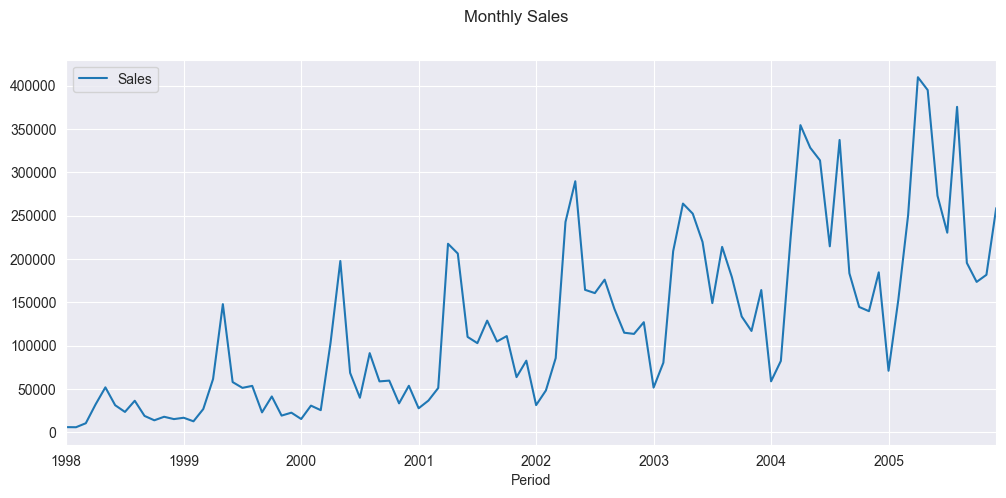

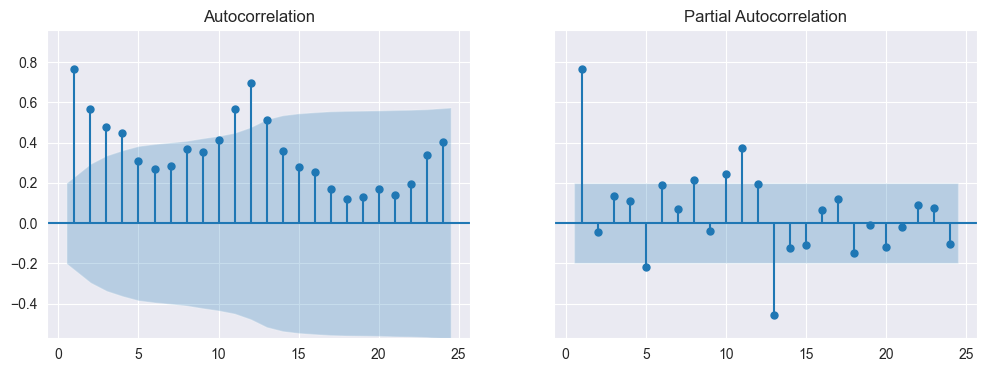

In [2]:
dataset = r".\dataset.xls"
df = pd.read_excel(dataset, parse_dates=True, index_col="Period")
sns.set_style("darkgrid")
df.plot(grid=True, subplots=True, title="Monthly Sales", figsize=(12,5))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True)
tsaplots.plot_acf(df["Sales"], lags=24, zero=False, ax=ax1, auto_ylims=True)
tsaplots.plot_pacf(df["Sales"], lags=24, zero=False, ax=ax2, auto_ylims=True)
plt.show()

### Time Series Decomposition

Applying a Multiplicative Model to address growing variance over time.

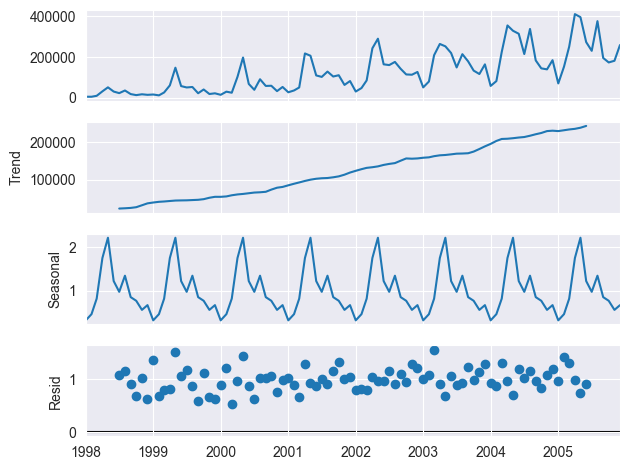

'Seasonal Indexes:'

Period
2005-01-01    0.321058
2005-02-01    0.463488
2005-03-01    0.820929
2005-04-01    1.757131
2005-05-01    2.223672
2005-06-01    1.225877
2005-07-01    0.977907
2005-08-01    1.349063
2005-09-01    0.855764
2005-10-01    0.771658
2005-11-01    0.562030
2005-12-01    0.671423
Name: seasonal, dtype: float64

In [3]:
seasonal_decomposition = seasonal_decompose(df, model="mul",period=12)
fig = seasonal_decomposition.plot()
plt.show()
display("Seasonal Indexes:",seasonal_decomposition.seasonal.tail(12))

We observe an upward trend in the data.  
The residuals exhibit a random and evenly dispersed pattern, indicating no discernible structure.  
In terms of seasonality, elevated sales are evident in April and May, while lower sales occur between November and February.

#### Train-Test Split

In [4]:
X_train=df.loc[:"2004-12-01"]
X_test=df.loc["2005-01-01":]

### Holt-Winters Exponential Smoothing

Model fitting and forecasting (plotting and metrics will be analyzed at the end).  
  
This model captures both trend and seasonality.

In [5]:
model_holt_winters = ExponentialSmoothing(X_train, trend="mul", seasonal="mul",seasonal_periods=12, initialization_method="estimated").fit(optimized=True)
forecast_holt_winters = model_holt_winters.forecast(12)

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Residuals Analysis

The residuals exhibit consistency overall, with notable exceptions observed in 2001 and 2003, characterized by three significant underestimations during these years.

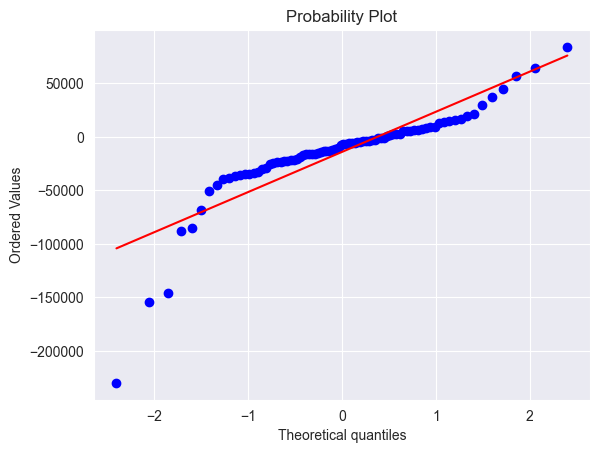

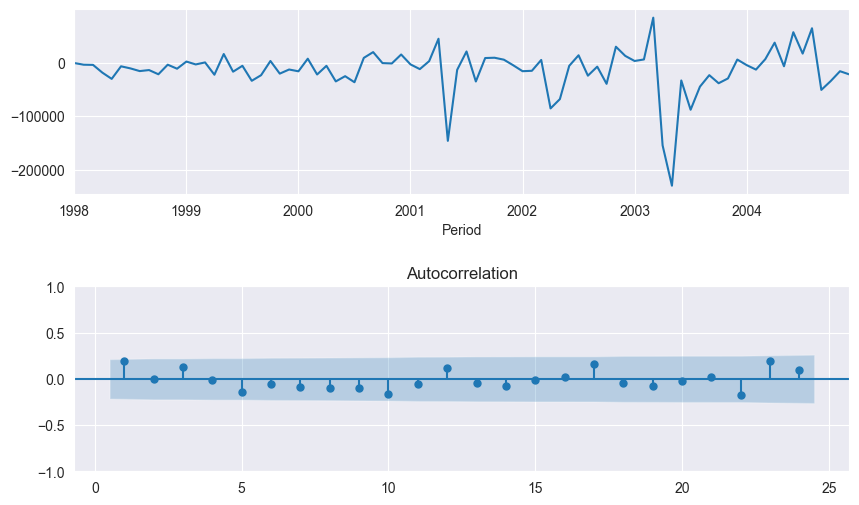

In [6]:
holt_winters_residuals = model_holt_winters.resid
stats.probplot(holt_winters_residuals, dist="norm", plot=plt)
plt.show()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), gridspec_kw={'hspace': 0.5})
holt_winters_residuals.plot(ax=ax1)
tsaplots.plot_acf(holt_winters_residuals, lags=24, zero=False, ax=ax2)
plt.show()

### SARIMA  

SARIMA (Seasonal AutoRegressive Integrated Moving Average):

We perform an initial regular differencing and a seasonal differencing on the log series. We observe that the differenced series fluctuates randomly around zero and exhibits reversion to the mean.

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17728\1960253722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Sales_diff1_diff12"] = np.log(X_train["Sales"]).diff(1).diff(12)


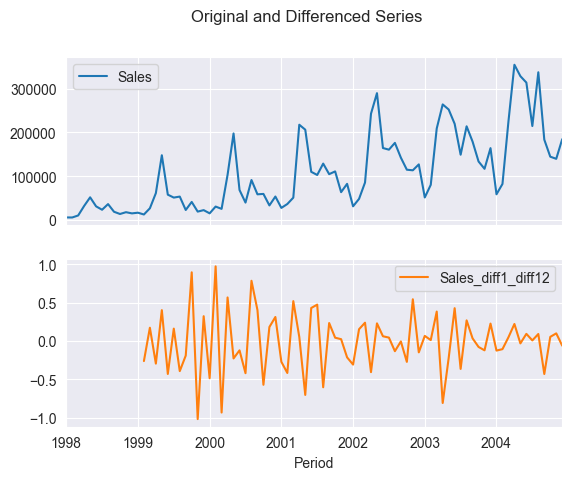

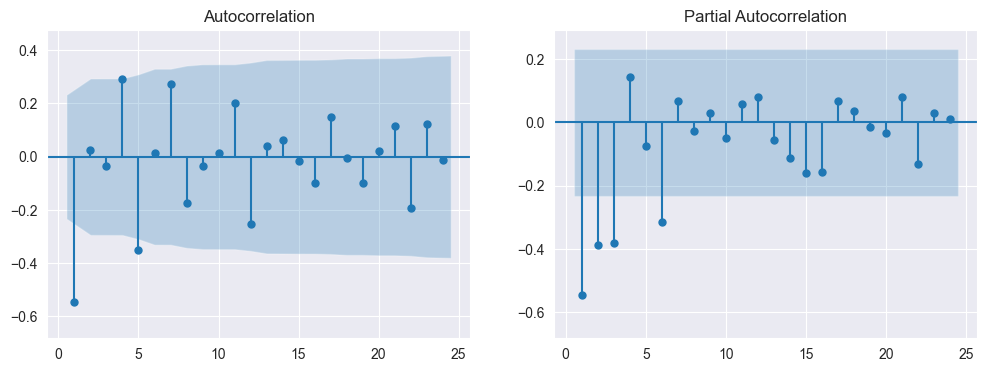

In [7]:
X_train["Sales_diff1_diff12"] = np.log(X_train["Sales"]).diff(1).diff(12)
X_train.plot(subplots=True, title="Original and Differenced Series")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
tsaplots.plot_acf(X_train["Sales_diff1_diff12"].dropna(), lags=24, zero=False,ax=ax1, auto_ylims=True)
tsaplots.plot_pacf(X_train["Sales_diff1_diff12"].dropna(), lags=24, zero=False,ax=ax2, auto_ylims=True)
plt.show()

An __Augmented Dickey–Fuller__ test is performed to test stationarity, which is confirmed by the low p-value.

In [8]:
print("Augmented Dickey-Fuller p-value: ", \
adfuller(X_train["Sales_diff1_diff12"].dropna())[1])

Augmented Dickey-Fuller p-value:  2.3473537095996916e-06


Model fitting and forecasting.

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -10.226
Date:                            Mon, 09 Sep 2024   AIC                             26.452
Time:                                    14:55:11   BIC                             33.240
Sample:                                01-01-1998   HQIC                            29.152
                                     - 12-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8096      0.074    -10.996      0.000      -0.954      -0.665
ma.S.L12      -0.3421      0.152   

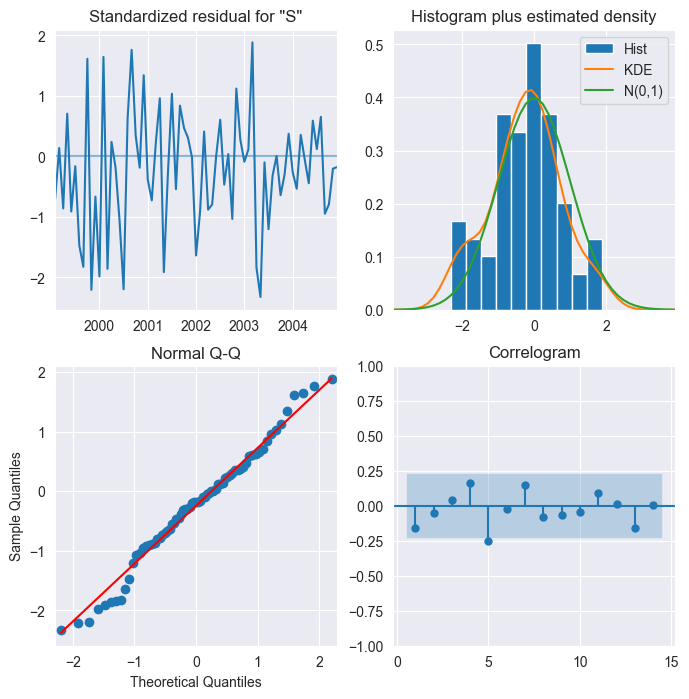

In [9]:
model_SARIMA = SARIMAX(np.log(X_train["Sales"]),order=(0,1,1),seasonal_order=(0,1,1,12), concentrate_scale= False).fit()
print(model_SARIMA.summary())
model_SARIMA.plot_diagnostics(lags=14, figsize=(8,8), acf_kwargs={"zero":False})
plt.show()

forecast_SARIMA = model_SARIMA.get_forecast(steps=12)

I've selected the model with lower AIC and RMSE. The residuals of the SARIMA model exhibit consistency, and the estimated parameters are different from 0 with statistical significance.  
  
Additionally, both the Ljung-Box test for autocorrelation in residuals and the Jarque-Bera test for normality provide satisfactory results (although there is a slightly significant autocorrelation at lag 5).  
  
These findings contribute to the validity and reliability of the SARIMA model, indicating that it adequately captures the temporal dependencies and distributional characteristics of the underlying time series data

Holt-Winters RMSE: 37,954
SARIMA RMSE: 35,705


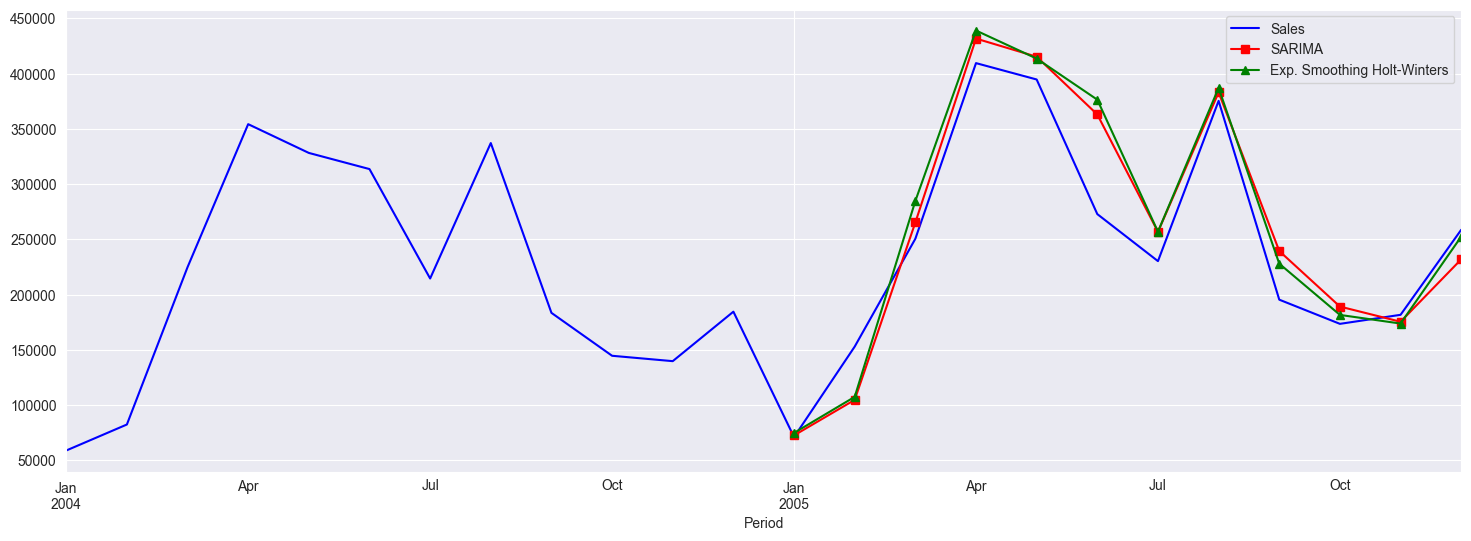

In [19]:
print("Holt-Winters RMSE: {:,.0f}".format(np.sqrt(mean_squared_error(X_test,forecast_holt_winters))))
print("SARIMA RMSE: {:,.0f}".format(np.sqrt(mean_squared_error(X_test,np.exp(forecast_SARIMA.predicted_mean)))))

fig, ax=plt.subplots(1,1, figsize=(18,6))
df["Sales"].iloc[-24:].plot(ax=ax, label="Sales", color="blue")
np.exp(forecast_SARIMA.predicted_mean).plot(ax=ax, color="red", label="SARIMA", marker="s")
forecast_holt_winters.plot(ax=ax, color="green", label="Exp. Smoothing Holt-Winters", marker="^")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

print("Holt-Winters MAE: {:,.0f}".format(mean_absolute_error(X_test,forecast_holt_winters)))
print("SARIMA MAE: {:,.0f}".format(mean_absolute_error(X_test,np.exp(forecast_SARIMA.predicted_mean))))
print("Holt-Winters MAPE: {:.4f}".format(mean_absolute_percentage_error(X_test,forecast_holt_winters)))
print("SARIMA MAPE: {:.4f}".format(mean_absolute_percentage_error(X_test,np.exp(forecast_SARIMA.predicted_mean))))

Holt-Winters MAE: 27,380
SARIMA MAE: 27,036
Holt-Winters MAPE: 0.1178
SARIMA MAPE: 0.1185


### Conclusion  

Although both models captures trend and seasonality, SARIMA has a slightly lower Root Mean Squared Error against Holt-Winters.  
I've chosen RMSE due to its sensitivity to magnitude (penalizes large errors more heavily than smaller errors) and interpretability (it's in the same units as the target variable).

Exogenous variables can be added conforming a SARIMAX model in order to increase model performance.
